In [ ]:
import dlib, cv2, os
from imutils import face_utils
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# gdrive 연결
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
cd /content/gdrive/My Drive/edu/elice/dog_face

/content/gdrive/My Drive/edu/elice/dog_face


filename hunter640
ext .jpg


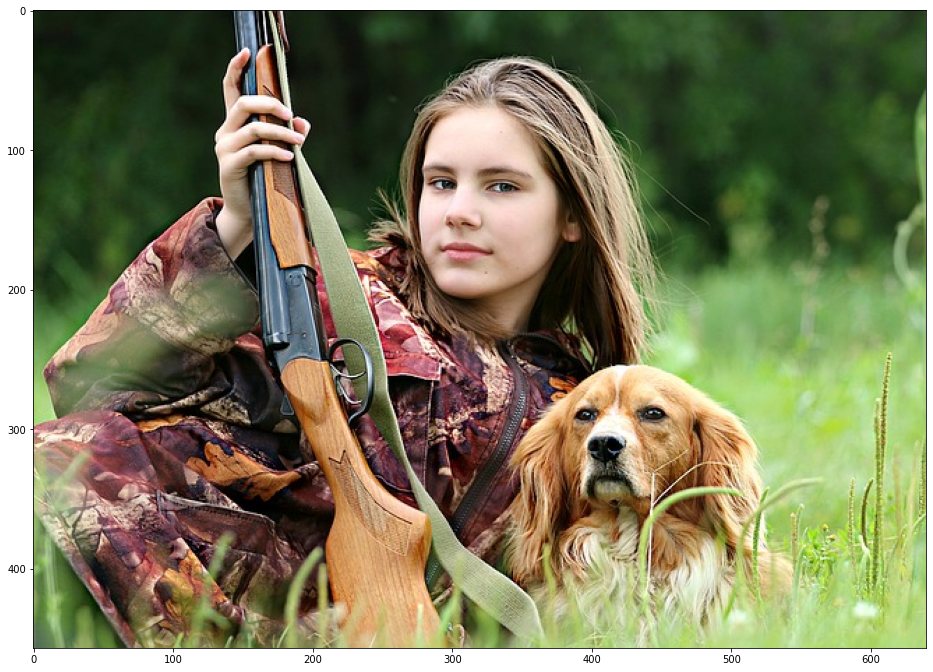

In [ ]:
# image read Dog    by  cv2  

img_path = 'img/hunter640.jpg'

# 확장자 분리 split ext
filename, ext = os.path.splitext(os.path.basename(img_path))

print('filename', filename)
print('ext', ext)

img = cv2.imread(img_path) # imread 특성 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16,16))
plt.imshow(img)

In [ ]:
# load models
# cnn 디텍터가 gpu 요구시, 런타임 -> 런타임 유형 변경 -> gpu 선택
detector = dlib.cnn_face_detection_model_v1('dogHeadDetector.dat') # 강아지 얼굴 검출
predictor = dlib.shape_predictor('landmarkDetector.dat') # 강아지 얼굴 내에 중요 지점 (landmark) 추정

In [ ]:
# detect faces

dets = detector(img, upsample_num_times=1)
print(dets)

mmod_rectangles[[(355, 245) (473, 363)]]


Detection 0: Left: 355 Top: 245 Right: 473 Bottom: 363 Confidence: 1.0514860153198242


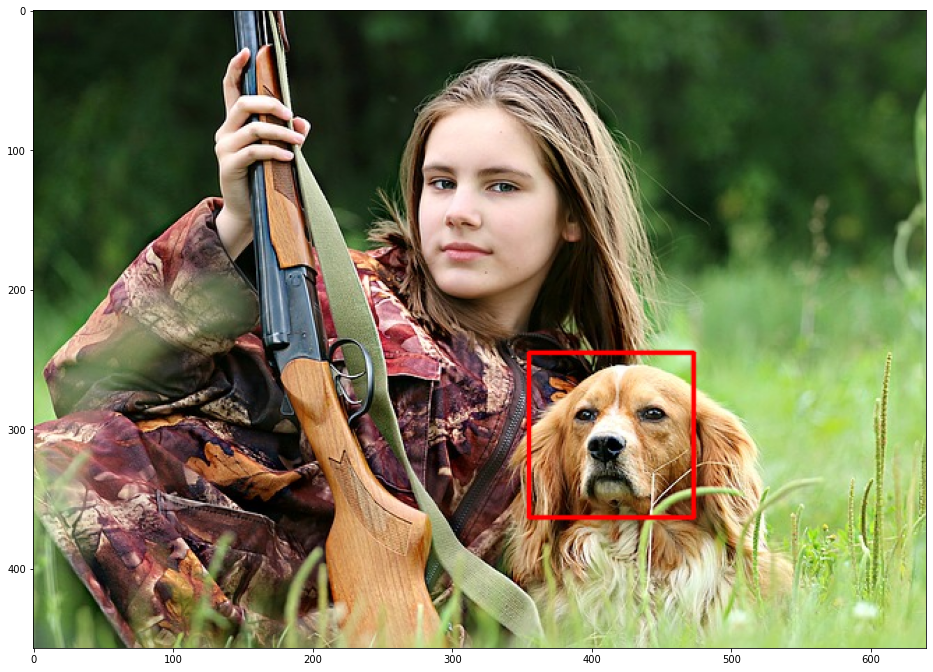

In [ ]:
# img 에다가 검출된 rectangle 표현
img_result = img.copy() # 원본 카피해놓기

for i, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {} Confidence: {}".format(i, d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom(), d.confidence))
    x1, y1 = d.rect.left(), d.rect.top()
    x2, y2 = d.rect.right(), d.rect.bottom()

    cv2.rectangle(img_result, pt1=(x1,y1), pt2=(x2,y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)

plt.figure(figsize=(16,16))
plt.imshow(img_result)


True

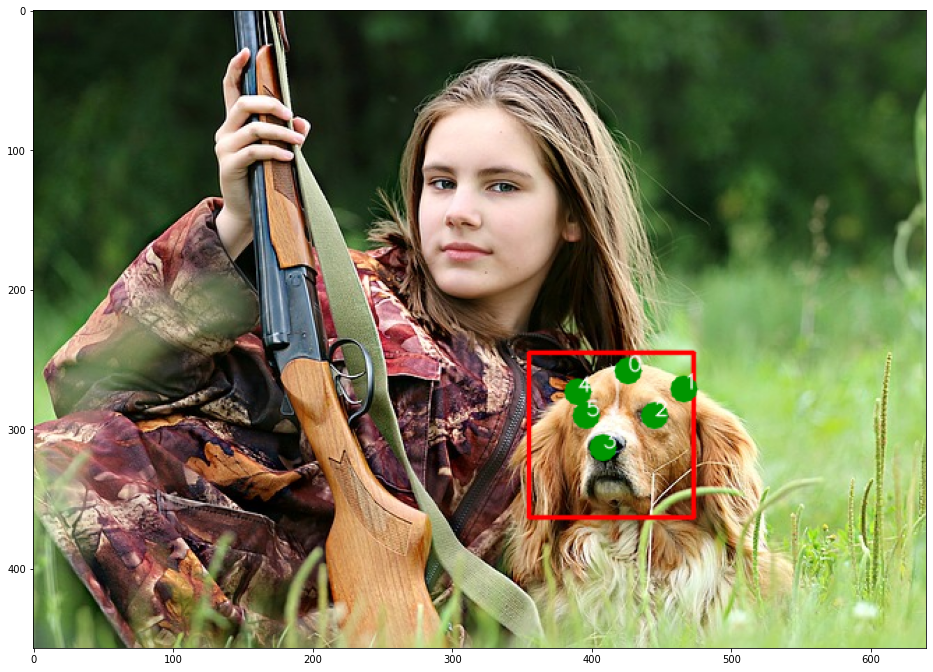

In [ ]:
# predict landmarks

shapes = []

for i, d in enumerate(dets):
  shape = predictor(img, d.rect)
  shape = face_utils.shape_to_np(shape)
  shapes.append(shape)

  for i, p in enumerate(shape):
    cv2.circle(img_result, center= tuple(p),  radius = 3, color = (0,150,0), thickness=1, lineType=cv2.LINE_AA)
    cv2.putText(img_result, str(i), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA )
plt.figure(figsize=(16,16))
plt.imshow(img_result)

# 저장하고 싶다면
img_out = cv2.cvtColor(img_result, cv2.COLOR_RGB2BGR)
cv2.imwrite('img/%s_out%s' % (filename, ext), img_out)

In [ ]:
# 뿔과 코 달아주기   over lay

from math import atan2, degrees

def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
  img_to_overlay_t = cv2.cvtColor(img_to_overlay_t, cv2.COLOR_BGRA2RGBA)
  bg_img = background_img.copy()
 ##-복붙 시작점
  if bg_img.shape[2] == 3:
      bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGB2RGBA)

  if overlay_size is not None:
      img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

  b, g, r, a = cv2.split(img_to_overlay_t)

  mask = cv2.medianBlur(a, 5)

  h, w, _ = img_to_overlay_t.shape
  roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]

  img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
  img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)

  bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)

 ## 복붙 끝점
  bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGBA2RGB)
  return bg_img

In [ ]:
def angle_between(p1, p2):
  xDiff = p2[0] - p1[0]
  yDiff = p2[1] - p1[1]
  return degrees(atan2(yDiff, xDiff))

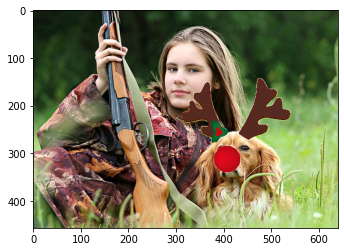

In [ ]:
img_result2 = img.copy()

horns = cv2.imread('img/horns2.png', cv2.IMREAD_UNCHANGED)
horns_h, horns_w = horns.shape[:2]

nose = cv2.imread('img/nose.png', cv2.IMREAD_UNCHANGED)

# 랜드마크 들의 관계를 이용해서 그림 배치 (예: 뿔은 중심점 배치가 필요함)
for shape in shapes:
  horns_center = np.mean([shape[1], shape[4]], axis=0) // [1, 1.3]
  horns_size = np.linalg.norm(shape[4]-shape[1]) * 3

  nose_center = shape[3]
  nose_size = horns_size // 4

  angle = -angle_between(shape[4], shape[1])

  M = cv2.getRotationMatrix2D((horns_w, horns_h), angle, 1)
  rotated_horns = cv2.warpAffine(horns, M, (horns_w, horns_h))

  img_result2 = overlay_transparent(img_result2, nose, nose_center[0], nose_center[1], overlay_size=(int(nose_size), int(nose_size)))
  img_result2 = overlay_transparent(img_result2, rotated_horns, horns_center[0], horns_center[1], overlay_size=(int(horns_size), int(horns_h * horns_size / horns_w)))

# imshow 그리고 imwrite
plt.imshow(img_result2)